In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error

[*********************100%%**********************]  1 of 1 completed


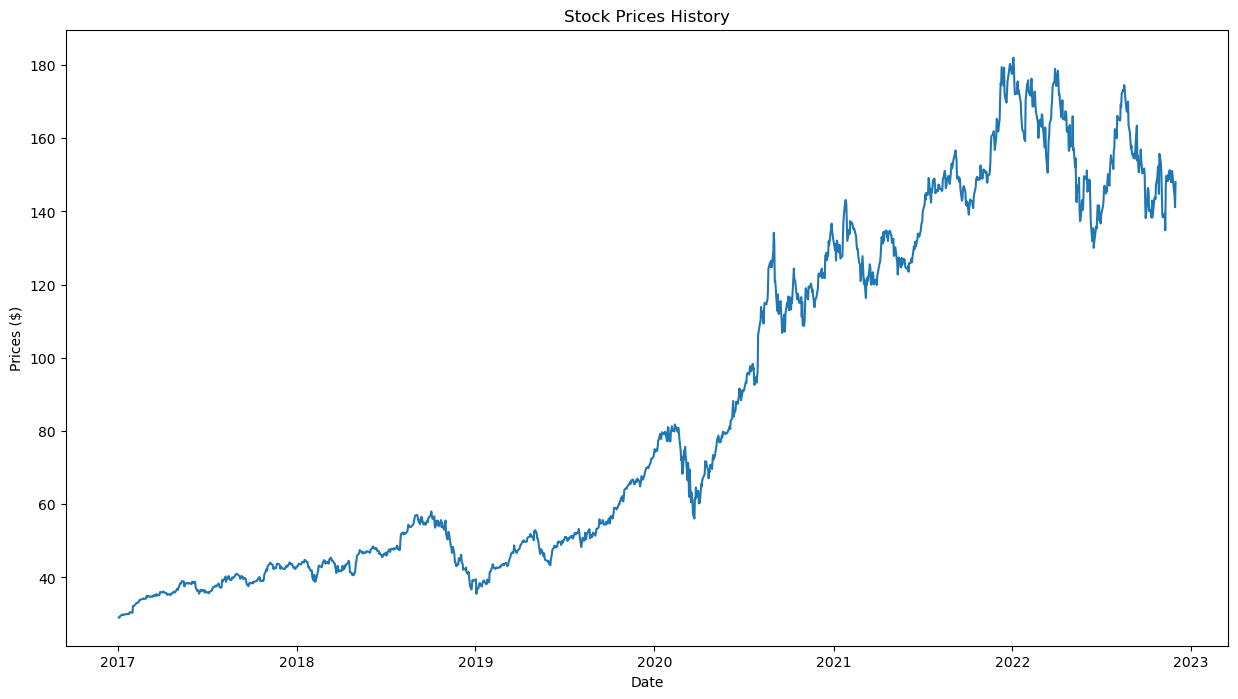

              Predictions                Actual
0    [141.95843505859375]  [140.91000366210938]
1    [141.16693115234375]  [143.75999450683594]
2    [141.81002807617188]  [144.83999633789062]
3     [143.7239532470703]   [146.5500030517578]
4    [145.05050659179688]  [148.75999450683594]
..                    ...                   ...
281  [147.84803771972656]  [151.07000732421875]
282  [148.93673706054688]  [148.11000061035156]
283   [147.2613983154297]  [144.22000122070312]
284  [145.55654907226562]   [141.1699981689453]
285  [144.71607971191406]  [148.02999877929688]

[286 rows x 2 columns]
predictionsshape (286, 1)


/tmp/ipykernel_17607/498521475.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


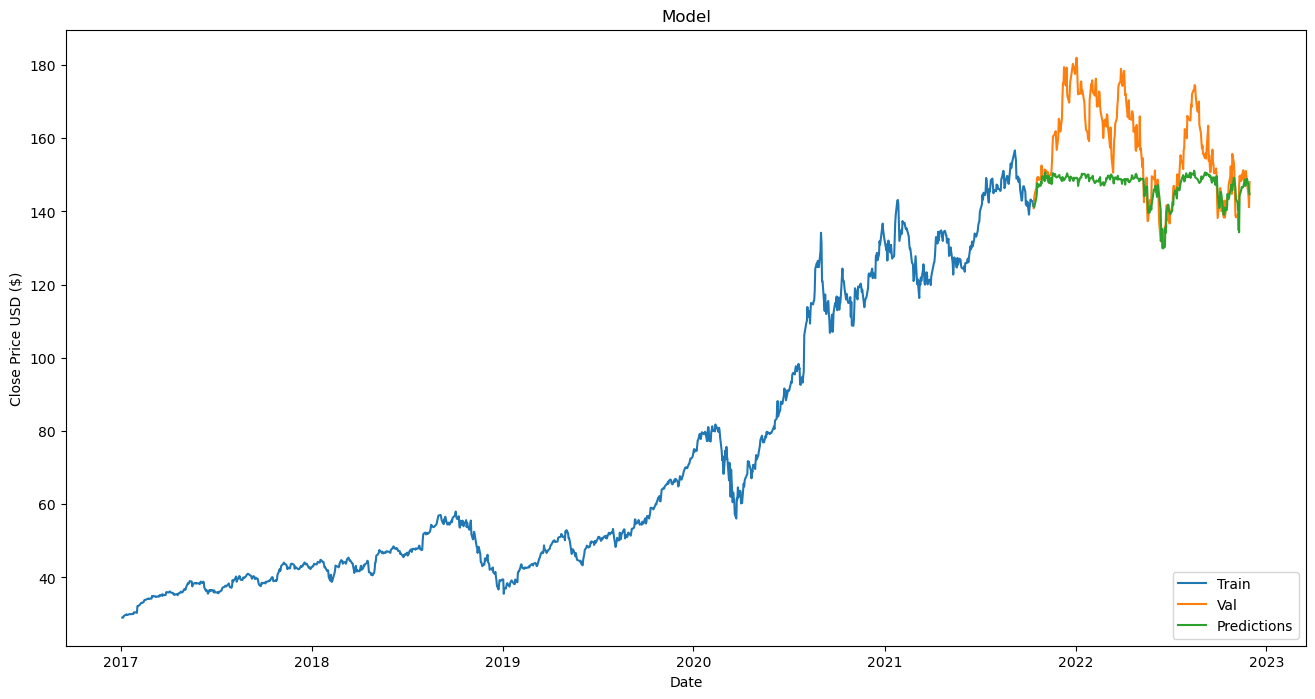

Root Mean Squared Error (RMSE): 14.337424324354085


In [5]:
class StockAnalysis:
    def __init__(self, stock_symbol, start_date, end_date):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date

    def download_stock_data(self):
        stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)
        return stock_data

    def plot_stock_prices(self, data):
        plt.figure(figsize=(15, 8))
        plt.title('Stock Prices History')
        plt.plot(data['Close'])
        plt.xlabel('Date')
        plt.ylabel('Prices ($)')
        plt.show()

    def prepare_data(self, stock_data):
        values = stock_data.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(values)
        scaled_df = pd.DataFrame(scaled_data, columns=stock_data.columns)
        close_prices = scaled_df['Close']

        window_size = 60

        x_data = []
        y_data = []

        for i in range(len(scaled_data) - window_size):
            x_window = scaled_data[i:i + window_size]
            y_window = close_prices.iloc[i + window_size]
            x_data.append(x_window)
            y_data.append(y_window)

        x_data, y_data = np.array(x_data), np.array(y_data)

        split_ratio = 0.8
        split_index = int(len(x_data) * split_ratio)

        x_train, x_test = x_data[:split_index], x_data[split_index:]
        y_train, y_test = y_data[:split_index], y_data[split_index:]

        return x_train, x_test, y_train, y_test

    def train_xgboost_model(self, x_train, y_train):
        model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
        model.fit(x_train.reshape(x_train.shape[0], -1), y_train)
        return model

    def evaluate_model(self, model, x_test, y_test, stock_data):
        predictions = model.predict(x_test.reshape(x_test.shape[0], -1))
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(stock_data['Close'].values.reshape(-1, 1))
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

        predictions_list = predictions.tolist()
        Actual = y_test.tolist()

        df = pd.DataFrame({'Predictions': predictions_list, 'Actual': Actual})
        print(df)

        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        return rmse,predictions

    def plot_training_validation_predictions(self, stock_data, x_test, predictions):
        print("predictionsshape",predictions.shape)
        data = stock_data.filter(['Close'])
        training_data_len = len(stock_data) - len(x_test)
        train = data[:training_data_len]
        validation = data[training_data_len:]
        validation['Predictions'] = predictions

        plt.figure(figsize=(16, 8))
        plt.title('Model')
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.plot(train)
        plt.plot(validation[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

    def analyze_stock(self):
        stock_data = self.download_stock_data()
        self.plot_stock_prices(stock_data)
        x_train, x_test, y_train, y_test = self.prepare_data(stock_data)
        model = self.train_xgboost_model(x_train, y_train)
        rmse,predictions = self.evaluate_model(model, x_test, y_test, stock_data)
        self.plot_training_validation_predictions(stock_data, x_test, predictions)
        return rmse

if __name__ == "__main__":
    stock_symbol = 'AAPL'
    start_date = '2017-01-01'
    end_date = '2022-12-01'
    stock_analyzer = StockAnalysis(stock_symbol, start_date, end_date)
    
    rmse = stock_analyzer.analyze_stock()
    print(f"Root Mean Squared Error (RMSE): {rmse}")
